In [1]:
import ipyleaflet
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipyleaflet import (
    Map,
    Marker, basemap_to_tiles, basemaps,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,SplitMapControl
)

## Visualizing the distribution coefficients on a map

## Loading libraries and information

### Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [4]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [5]:
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

###  Load stations information

In [6]:
data_dir='../Data/Weather/'
!du -sh $data_dir/*

133M	../Data/Weather//CA.parquet
109M	../Data/Weather//CA.tgz
77M	../Data/Weather//NY.parquet
64M	../Data/Weather//NY.tgz
50M	../Data/Weather//STAT_CA.pickle
25M	../Data/Weather//STAT_NY.pickle
49M	../Data/Weather//STAT_WA.pickle
75M	../Data/Weather//WA.parquet
62M	../Data/Weather//WA.tgz
348K	../Data/Weather//Weather_Stations.tgz
3.0M	../Data/Weather//decon_CA_PRCP_s20.parquet
2.7M	../Data/Weather//decon_CA_SNWD_s20.parquet
1.4M	../Data/Weather//decon_CA_TOBS_s20.parquet
7.6M	../Data/Weather//decon_WA_PRCP_s20.parquet
3.0M	../Data/Weather//recon_CA_PRCP_s20.parquet
2.7M	../Data/Weather//recon_CA_SNWD_s20.parquet
7.6M	../Data/Weather//recon_WA_PRCP_s20.parquet
420K	../Data/Weather//stations.parquet


In [7]:
stations_df=sqlContext.read.parquet(data_dir+'/stations.parquet')
stations_df.show(3)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 3 rows



### Load the reconstructions DataFrame

For details about the columns in this DataFrame see the README notebook

In [28]:
### Read the data frame from a parquet file.

state='CA'
meas='SNWD_s20'

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(1)

4997
+-----------+-----------+--------------------+----+------------------+-------------------+-------------------+-----------------+-------------------+---------------+-----------------+-----------------+------------------+------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-----------------+
|Measurement|    Station|              Values|Year|           coeff_1|            coeff_2|            coeff_3|          coeff_4|            coeff_5|     dist_coast|        elevation|         latitude|         longitude|        name|             res_1|             res_2|              res_3|              res_4|              res_5|           res_mean|        total_var|
+-----------+-----------+--------------------+----+------------------+-------------------+-------------------+-----------------+-------------------+---------------+-----------------+-----------------+------------------+------------+------------------+------

## Compute the count and average of `coef_1` for each station.

In [29]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,Dist_coast,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)

df2=df1.groupby(['station','latitude','longitude','elevation','Dist_coast']).agg({"station": "count", feature: "mean"})
#df2=df1.groupby(['station']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(5)

SELECT station, latitude,longitude,elevation,Dist_coast,coeff_1 FROM weather


,station,latitude,longitude,elevation,Dist_coast,count(station),avg(coeff_1)
82,USC00040029,41.193600,-120.944702,1278.599976,263.226013,14,-56.534905
60,USC00040161,41.493099,-120.552803,1341.099976,294.410004,7,-25.253568
166,USC00040204,35.983299,-119.483299,64.000000,142.335999,1,110.999834
219,USC00040327,34.216702,-118.166702,371.899994,38.856899,2,-140.183105
106,USC00040343,36.491402,-118.825302,520.599976,220.867004,4,113.864696


In [30]:
# Find long/lat bounding box
max_long=pdf['longitude'].max()
min_long=pdf['longitude'].min()
max_lat=pdf['latitude'].max()
min_lat=pdf['latitude'].min()


In [31]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('gnuplot_r')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))


## Map
* Each circle is centered at a station.  
* The area of the circle corresponds to the number of years SNWD was recorded at the station.  
* The color fill of the circle corresponds to the value of `avg(coeff_1)` defined by color-bar.

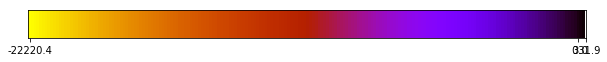

In [32]:
#def color_bar(_min,_max)
import pylab as plt
from matplotlib.pyplot import xticks,yticks
figure(figsize=[10,1])
ax = plt.subplot(111)
vals=cmap(np.arange(0,1,0.005))[:,:3]
vals3=np.stack([vals]*10)
vals3.shape
ax.imshow(vals3);

midpoint=200.*-_min/(_max-_min)
xticks((0,midpoint,200),["%4.1f"%v for v in (_min,0.,_max)])
yticks(());


In [34]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 6
#default_tiles=TileLayer(opacity=1.0),
m = Map( center=center, zoom=zoom)
left =basemap_to_tiles(basemaps.OpenMapSurfer.Grayscale) 
right = basemap_to_tiles(basemaps.Stamen.Terrain)
control = SplitMapControl(left_layer=left, right_layer=right)
m.add_control(control)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1200*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[37.33334922790527, -120.01570129394531], controls=(SplitMapControl(left_layer=TileLayer(attribution='Imagery from <a href="http://giscience.uni-hd.de/">GIScience Research Group @ University of Heidelberg</a> &mdash; Map data &copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>', max_zoom=19, min_zoom=1, name='OpenMapSurfer.Grayscale', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size'], url='http://korona.geog.uni-heidelberg.de/tiles/roadsg/x={x}&y={y}&z={z}'), right_layer=TileLayer(attribution='Map tiles by <a href="http://stamen.com/">Stamen Design</a>, under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org/">OpenStreetMap</a>, under <a href="http://creativecommons.org/licenses/by-sa/3.0">CC BY SA</a>.', name='Stamen.Terrain', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size'], url='http://stamen-tiles-a.a.ssl.fastly.net/terrain/{z}/{x}/{y}.png')),), layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), Rectangle(bounds=[[32.66669845581055, -124.2146987915039], [42.0, -115.81670379638672]], fill_opacity=0.0, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'no_clip', 'opacity', 'pointer_events', 'smooth_factor', 'stroke', 'weight']), Circle(color='#F00', fill_color='#200019', fill_opacity=0.4, location=[41.193599700927734, -120.9447021484375], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=4489, weight=1), Circle(color='#F00', fill_color='#200019', fill_opacity=0.4, location=[41.493099212646484, -120.55280303955078], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=3174, weight=1), Circle(color='#F00', fill_color='#17000d', fill_opacity=0.4, location=[35.983299255371094, -119.4832992553711], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=1200, weight=1), Circle(color='#F00', fill_color='#24001f', fill_opacity=0.4, location=[34.21670150756836, -118.16670227050781], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=1697, weight=1), Circle(color='#F00', fill_color='#17000d', fill_opacity=0.4, location=[36.49140167236328, -118.82530212402344], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=2400, weight=1), Circle(color='#F00', fill_color='#200019', fill_opacity=0.4, location=[37.09189987182617, -119.51280212402344], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=3600, weight=1), Circle(color='#F00', fill_color='#17000d', fill_opacity=0.4, location=[38.90719985961914, -121.08390045166016], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=2400, weight=1), Circle(color='#F00', fill_color='#100006', 

### Something to try
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

### Is coef_1 related to elevation ?

(-100, 1000)

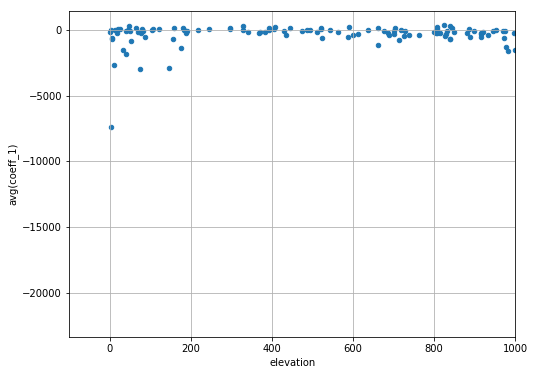

In [35]:
pdf.plot.scatter(x='elevation',y='avg(coeff_1)',figsize=(8,6));
grid()
xlim([-100,1000])

## Summary
* We saw how to use `ipyLeaflet` to present data on top of maps.
* We saw that in NY state, most of the snow accumulation is in the Adirondacks.
* Snow accumulation increases with elevation, but the relationship is weak: locations with elevation 400-600 meters have widely varying accumulations of snow.

## See you next time